## Classify candlestick patterns

All patterns in https://thepatternsite.com/Candles2.html will be detected and classified into bullish/ bearish. Assume taking long/short positions at t=0candle accordingly with suitable stop loss/gain, calculate the profit earned at t=5, 10, 15, 20candles. Each candle represent a 1h or 4hr interval. 

In [ ]:
import time
# import warnings
from datetime import datetime, timezone
from typing import List, Union
import requests
import pandas as pd
from price_data import BinanceAPI 
from matplotlib import pyplot as plt

In [5]:
bn = BinanceAPI()
btc_4h = bn.get_kline(symbol = 'BTCUSDT', interval = '4h', instrument_type='spot',start_date = '2020-01-01 00:00:00', end_date='2021-12-31 23:59:59')
btc_4h[['open', 'high', 'low', 'close', 'volume']
       ] = btc_4h[['open', 'high', 'low', 'close', 'volume']].astype(float)
btc_4h

{'symbol': 'BTCUSDT', 'interval': '4h', 'startTime': 1577836800000, 'endTime': 1592236800000, 'limit': 1000}
{'symbol': 'BTCUSDT', 'interval': '4h', 'startTime': 1592236800000, 'endTime': 1606636800000, 'limit': 1000}
{'symbol': 'BTCUSDT', 'interval': '4h', 'startTime': 1606636800000, 'endTime': 1621036800000, 'limit': 1000}
{'symbol': 'BTCUSDT', 'interval': '4h', 'startTime': 1621036800000, 'endTime': 1635436800000, 'limit': 1000}
{'symbol': 'BTCUSDT', 'interval': '4h', 'startTime': 1635436800000, 'endTime': 1649836800000, 'limit': 1000}


,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
date_time,,,,,,,,,,,,
2020-01-01 00:00:00,1.577837e+12,7195.24000000,7245.00000000,7175.46000000,7225.01000000,2833.74918000,1577851199999,20445895.80179560,32476,1548.86561900,11176594.41972043,0
2020-01-01 04:00:00,1.577851e+12,7225.00000000,7236.27000000,7199.11000000,7209.83000000,2061.29505100,1577865599999,14890182.27509305,29991,1049.71123600,7582850.37593562,0
2020-01-01 08:00:00,1.577866e+12,7209.83000000,7237.73000000,7180.00000000,7197.20000000,3166.65436100,1577879999999,22807318.59055887,33507,1562.34431400,11253695.89627296,0
2020-01-01 12:00:00,1.577880e+12,7197.20000000,7255.00000000,7196.15000000,7234.19000000,3492.53745900,1577894399999,25235559.66071409,36549,2086.27911900,15076709.32825345,0
2020-01-01 16:00:00,1.577894e+12,7234.20000000,7249.99000000,7214.00000000,7229.48000000,2980.58329100,1577908799999,21561774.16981082,32877,1673.06059400,12104158.06723686,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-12 12:00:00,1.649765e+12,40378.00000000,40699.00000000,39800.00000000,40179.13000000,16444.55750000,1649779199999,663080752.64485960,284365,8108.12474000,326948103.60712480,0
2022-04-12 16:00:00,1.649779e+12,40179.12000000,40376.80000000,39261.39000000,39303.10000000,10032.65806000,1649793599999,399595965.13431930,207063,4683.31454000,186536182.62138930,0
2022-04-12 20:00:00,1.649794e+12,39303.10000000,40289.02000000,39254.63000000,40074.94000000,6376.61560000,1649807999999,253299004.11652590,149047,3217.81490000,127856648.43190010,0


In [52]:
def compute_ret_profit(signal, stop_loss,stop_gain, start_cand:int, exposure:int):
  open_price = btc_4h['open'].iloc[start_cand]
  exit_price = None
  
  if signal == 'bull':  # long position
    for cand in range(start_cand, start_cand+exposure):
      if btc_4h['low'].iloc[cand] <= stop_loss:
        exit_price = stop_loss
      elif btc_4h['high'].iloc[cand] >= stop_gain:
        exit_price = stop_gain
    exit_price = btc_4h['close'].iloc[start_cand+exposure-1]
    profit = exit_price - open_price
    return  profit/open_price, profit
  
  elif signal == 'bear': # short position
    for cand in range(start_cand, start_cand+exposure):
      if btc_4h['high'].iloc[cand] >= stop_loss:
        exit_price = stop_loss
      elif btc_4h['low'].iloc[cand] <= stop_gain:
        exit_price = stop_gain
    exit_price = btc_4h['close'].iloc[start_cand+exposure-1]
    profit = open_price - exit_price
    return profit/open_price, profit
  
  return None, None

In [87]:
def above_the_stomach(i) -> Union[dict, None]:
  conditions = [btc_4h['open'].iloc[i-3] > btc_4h['close'].iloc[i-3],
                btc_4h['open'].iloc[i-2] > btc_4h['close'].iloc[i-2] ,
                btc_4h['open'].iloc[i-1] > btc_4h['close'].iloc[i-1] ,
                btc_4h['open'].iloc[i] > btc_4h['close'].iloc[i],
                btc_4h['open'].iloc[i+1] < btc_4h['close'].iloc[i+1],
                btc_4h['open'].iloc[i+2] >= (btc_4h['open'].iloc[i] + btc_4h['close'].iloc[i])/2]
  if not all(conditions): 
    return None, None, None
  # print(i)
  stop_loss = btc_4h['open'].iloc[i] * .9995
  stop_gain = (btc_4h['close'].iloc[i+1] - stop_loss) *3 +btc_4h['close'].iloc[i+1]
  return 'bull', stop_loss, stop_gain

In [ ]:
patterns = [above_the_stomach]

,ret,profit,exposure
count,69.000000,69.000000,69.0
mean,0.005740,183.842464,3.0
std,0.022091,787.899673,0.0
min,-0.040276,-2546.960000,3.0
25%,-0.006584,-188.610000,3.0
50%,0.001844,37.330000,3.0
75%,0.017646,549.220000,3.0
max,0.084154,2918.570000,3.0


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  3.,  1.,  2.,
         6.,  7., 13.,  9.,  6.,  2.,  2.,  1.,  7.,  2.,  1.,  1.,  1.,
         1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([-2546.96      , -2386.20911765, -2225.45823529, -2064.70735294,
        -1903.95647059, -1743.20558824, -1582.45470588, -1421.70382353,
        -1260.95294118, -1100.20205882,  -939.45117647,  -778.70029412,
         -617.94941176,  -457.19852941,  -296.44764706,  -135.69676471,
           25.05411765,   185.805     ,   346.55588235,   507.30676471,
          668.05764706,   828.80852941,   989.55941176,  1150.31029412,
         1311.06117647,  1471.81205882,  1632.56294118,  1793.31382353,
         1954.06470588,  2114.81558824,  2275.56647059,  2436.31735294,
         2597.06823529,  2757.81911765,  2918.57      ]),
 <BarContainer object of 34 artists>)

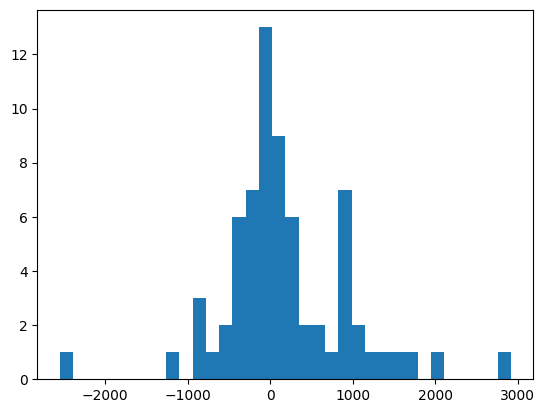

In [86]:
exposure= 3 # number of candle exposed to the position
df_1to3 = []

for i in range(3, len(btc_4h.index)-10):
  signal, stop_loss, stop_gain = above_the_stomach(i)
  # print(i)
  if signal == None:
    continue 
  start_cand = i+2
  ret, profit =  compute_ret_profit(signal=signal, stop_loss=stop_loss,
                                    stop_gain=stop_gain, start_cand=start_cand, exposure=exposure)
  df_1to3.append({'time': btc_4h.index[start_cand], 'signal': signal,
                 'ret': ret, 'profit': profit, 'exposure': exposure})

df_1to3 = pd.DataFrame(df_1to3).set_index('time', inplace=False)
display(df_1to3.describe())
plt.hist(df_1to3['profit'].sort_values(
    ignore_index=True), bins=int(len(df_1to3.index)/2))